# 17 Monte Carlo integration 

## How to find the numerical value of $\pi$ with random numbers?

Consider the quarter circle with radius $r=1$ in the first quadrant for $0 \le x, y \le 1$: 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib.collections import PatchCollection

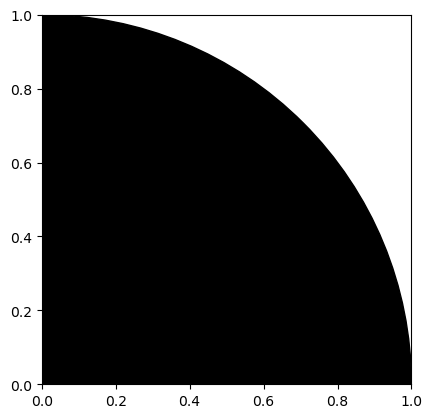

In [2]:
circle = matplotlib.patches.Circle((0,0), 1)
collections = PatchCollection([circle], color="black")

ax = plt.subplot()
ax.set_aspect(1)
ax.add_collection(collections);

Its area is
$$
A = \frac{1}{4} \pi r^2 = \frac{\pi}{4}
$$

If we can determine $A$, we can determine π
$$
\pi = 4A
$$

The **Monte Carlo** approach is to *estimate* the area from random points inside the square $[0, 1] \times [0, 1]$.

1. generate random point $k$
2. classify if the random point is inside the circle (black area) or outside (white area)

   $$
   a_k = \begin{cases}
   1, \quad\text{if}\ \sqrt{x^2 + y^2} \le 1\\
   0, \quad\text{if}\ \sqrt{x^2 + y^2} > 1
   \end{cases}
   $$
3. ratio of points inside vs all points is a measure of the area

   $$
   A = \frac{N_\text{inside}}{N} = \frac{1}{N}\sum_{k=1}^N a_k = \langle a \rangle
   $$

## Random numbers

In [3]:
import numpy as np

rng = np.random.default_rng(seed=20240418)

Note: if we all use `seed=20240418` we will all get the same random numbers.

### Generate random points:
Uniformly distributed

\begin{align}
(x, y)  &\sim \mathcal{U}_\text{[0, 1]} \times \mathcal{U}_\text{[0, 1]} \\
p_x(x) &= \begin{cases}
   1, \ 0 \le x \le 1\\
   0, \text{otherwise}
   \end{cases}
\end{align}   

In [4]:
xy = rng.uniform(low=0, high=1, size=(5, 2))
xy

array([[0.94772896, 0.79559945],
       [0.48474855, 0.89083455],
       [0.45560274, 0.46692758],
       [0.75156482, 0.19407641],
       [0.42773725, 0.65382028]])

## Classification function
Is the point inside the (quarter) circle?

In [5]:
def inside(xy, r=1):
    return np.sum(xy**2, axis=1) <= r**2

In [6]:
xy = rng.uniform(low=0, high=1, size=(1000, 2))

a = inside(xy)
area = np.mean(a)
pi_estimate = 4*area
error = 1 - pi_estimate/np.pi

print(f"area = {area} (with {len(a)} samples)")
print(f"pi = {pi_estimate} (error {error})")
print(f"pi = {np.pi} (numpy)")

area = 0.789 (with 1000 samples)
pi = 3.156 (error -0.004586000796043432)
pi = 3.141592653589793 (numpy)


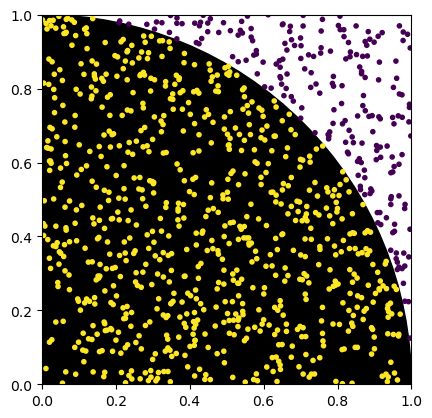

In [7]:
ax = plt.subplot()
ax.set_aspect(1)
ax.add_collection(PatchCollection([circle], color="black"))

ax.scatter(xy[:, 0], xy[:, 1], marker=".", c=a)
ax.set(xlim=(0, 1), ylim=(0, 1));

The method only converges slowly. But it is very simple and importantly, the evaluation inside/outside can be performed with elementary operations. The estimate will on average get better with increasing number of samples.

Effectively we evaluate the integral

$$
A = \int_0^1 \!\!\sqrt{1 - x^2} dx
$$

without having to explicitly do the integral!

## Weighted average method
(See *Computational Modelling*, Ch 10)

The goal is to calculate integrals of the form
$$
I = \int_a^b f(x) dx
$$
or in $M$ dimensions
$$
I = \prod_{i=1}^M\int_{a_i}^{b_i} \!\!dx_i f(x_1, x_2, \dots, x_M)
$$


### Problem: electrostatic potential energy between two spheres

Two charged, non-overlapping spheres of radii $R_1$ and $R_2$ at distance $d > R_1 + R_2$ interact via Coulomb's law. We choose the $x$ axis to pass through the two centers, so the *potential energy* $U$ of the two interacting charge distributions is

$$
U = k \int_{V_1}d\mathbf{r}_1 \int_{V_2}d\mathbf{r}_2 \frac{\rho_1(\mathbf{r}_1) \rho_2(\mathbf{r}_2)}{\sqrt{[\mathbf{r}_1 - (\mathbf{r}_2 + d\hat{\mathbf{e}}_x)]^2}}
$$

where we integrate over the volumes of each sphere, i.e., the position vectors $\mathbf{r}_1$ and $\mathbf{r}_2$ originate at the *center* of each sphere; with the origin chosen at the center of sphere 1, the *distance* between two points inside sphere 1 and sphere 2 is $\sqrt{[\mathbf{r}_1 - (\mathbf{r}_2 + d\hat{\mathbf{e}}_x)]^2}$. ($k$ contains the electrostatic constants, depending on the unit system.)

This is a 6-dimensional integral, in components it is

$$
U = k \int_{V_1}dx_1 dy_1 dz_1 \int_{V_2}dx_2 dy_2 dz_2 \frac{\rho_1(x_1, y_1, z_1) \rho_2(x_2, y_2, z_2)}{\sqrt{(x_1^2 - x_2^2 - d)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}}
$$

### Derivation of the weighted average method

The **weighted average** of a function $f(x)$ is

$$
\langle f \rangle = \int_a^b f(x) P(x) dx
$$

with a weighting function (or probability density) $P(x)$. 

$P(x)$ is **normalized**
$$
\int_a^b P(x) dx = 1
$$

so $P(x)dx$ is the probability to find something in the interval $[x, x+dx]$.

Discretize the space $[a, b]$ into intervals of length $\Delta x$ to approximate the integral as a Riemann sum

$$
\langle f \rangle \approx \sum_j f(x_j) P(x_j) \Delta x
$$

where each interval (or "bin") is $[x_j, x_j + \Delta x]$.

Randomly sample points according to $P(x)$, i.e., $x$ is distributed according to $P$: $x \sim P$.

Then $P(x_j) \Delta x$ is the probability for points falling into $[x_j, x_j + \Delta x]$ or

$$
P(x_j) \Delta x = \frac{n_j}{N}, \qquad N = \sum_j n_j
$$

where $n_j$ is the number of points in this interval.

Hence we can write the average with randomly sampled points as

$$
\langle f \rangle \approx \frac{1}{N} \sum_j f(x_j) n_j = \frac{1}{N} \sum_{i=1}^N f(x_i) \qquad(\{x_i\}\ \text{distributed as}\ P(x))
$$

Instead of summing over the individual intervals (or "bins") $[x_j, x_j+\Delta x]$ we are now summing over *all* data points (without having to know the intervals or the explicit probability distribution). But we **must ensure that the data points were sampled according to $P(x)$**.

In order to get the integral $I$ we choose a distribution $P(x)$ and figure out how $I$ and $\langle f \rangle$ are related. We choose the simplest distribution to start with:

#### Uniform distribution

For the **uniform distribution** on $[a, b]$ as weighting function

$$
P(x) = \frac{1}{b-a}
$$

the original weighted average integral is

$$
\langle f \rangle = \frac{1}{b-a} \int_a^b f(x) dx = \frac{1}{b-a} I
$$


and hence the integral $I$ that we seek to compute is

$$
I = \int_a^b f(x) dx = (b-a) \langle f \rangle_\text{mc}
$$

where we compute the weighted average as

$$
\langle f \rangle_\text{mc} = \frac{1}{N} \sum_{i=1}^N f(x_i) \qquad(\{x_i\}\ \text{uniformly distributed})
$$

with the samples coming from the uniform distribution on the interval $[a, b]$.

#### $M$-dimensional Monte Carlo integral
The MC integral with the uniform distributions generalizes directly to any dimensions:

$$
I = \int_{a_1}^{b_1} \cdots \int_{a_M}^{b_M} f(x_1, \dots, x_M) dx_1\cdots dx_M \approx V \langle f \rangle_\text{mc}
$$

where $V$ is the hypervolume of the integration domain.


Remarkably, Monte Carlo integration is one of the few methods that can tackle high dimensional integrals directly. Its accuracy is not decreased by an increase in dimensions; for sufficiently well behaved integrands, its accuracy only depends on the number of samples.

### Application to the charged sphere potential energy

$$
U = k \int_{V_1}dx_1 dy_1 dz_1 \int_{V_2}dx_2 dy_2 dz_2 \frac{\rho_1(x_1, y_1, z_1) \rho_2(x_2, y_2, z_2)}{\sqrt{(x_1^2 - x_2^2 - d)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2}}
$$

For uniform charge densities, the result is equivalent to two point charges with charges $Q_1 = \rho_1 V_1$ and $Q_2 = \rho_2 V_2$
$$
U = k \frac{Q_1 Q_2}{d}
$$
(the energy to bring the two charges to distance $d$ from infinity). For non-uniform $\rho_i$ the integral needs to be evaluated numerically. Here we will use the uniform charge density problem to test the MC integration approach. We use as parameters

* $R_1 = 1$, $R_2 = 2$, $\rho_1 = \rho_2 = 1$
* $d = 4$
* $U/k Q_1 Q_2 = \frac{1}{4}$ (analytical result)



Sample points inside a sphere of radius $R$ using the *rejection method*:

1. generate point $\mathbf{r}$ in the cube enclosing the sphere $[-R, R] \times [-R, R] \times [-R, R]$ from a uniform distribution.
2. if $\mathbf{r}^2 \le R^2$ then the point is inside: return $\mathbf{r}$, else goto 1.

(Note that we avoid taking a square root in $\sqrt{\mathbf{r}^2} \le R$ as this is a very expensive numerical operation that is not necessary here.)

In [8]:
R1 = 1.
R2 = 2.
rho1 = rho2 = 1.
d = 4.

N = 100

r1_values = rng.uniform(low=-R1, high=R1, size=(N, 3))
r2_values = rng.uniform(low=-R2, high=R2, size=(N, 3))        

### Classification function

In [9]:
def sample(r, radius):
    """sample point inside sphere via rejection"""
    inside = np.sum(r*r, axis=1) <= radius**2
    return r[inside]

In [10]:
sample(r1_values, R1)

array([[-0.77491163,  0.38790891, -0.16356375],
       [-0.17546164,  0.6917355 , -0.48382079],
       [ 0.50968242, -0.17649383,  0.58538185],
       [-0.64031221, -0.59897276,  0.11398596],
       [ 0.30952664, -0.19042944,  0.75177248],
       [-0.1057924 , -0.34855119,  0.39678119],
       [-0.14636159,  0.70862801,  0.4285339 ],
       [ 0.54616512,  0.44700793, -0.43782879],
       [-0.24159058,  0.54660634,  0.23901742],
       [-0.10739396,  0.28080247, -0.85124633],
       [-0.79603211,  0.04715291,  0.42410099],
       [-0.68459051,  0.37880107,  0.34427052],
       [-0.49978523, -0.13640746,  0.34775037],
       [ 0.71388364, -0.56513542, -0.15910646],
       [-0.30165335,  0.72133012,  0.18283736],
       [-0.17553051,  0.27942802, -0.7728102 ],
       [-0.74033846, -0.5361743 ,  0.08587038],
       [ 0.31813062,  0.50529585, -0.38960234],
       [-0.49804609,  0.58584711,  0.25543019],
       [ 0.60692362,  0.04677962, -0.44614479],
       [ 0.58857588,  0.3849513 , -0.221

Visualize our samples:

In [11]:
X1,Y1,Z1 = sample(r1_values, R1).T
X2,Y2,Z2 = sample(r2_values, R2).T
X2 += d

# plot sphere in 3d (from https://stackoverflow.com/a/63708529)
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x1 = R1*np.cos(u)*np.sin(v)
y1 = R1*np.sin(u)*np.sin(v)
z1 = R1*np.cos(v)

x2 = R2*np.cos(u)*np.sin(v) + d
y2 = R2*np.sin(u)*np.sin(v)
z2 = R2*np.cos(v)

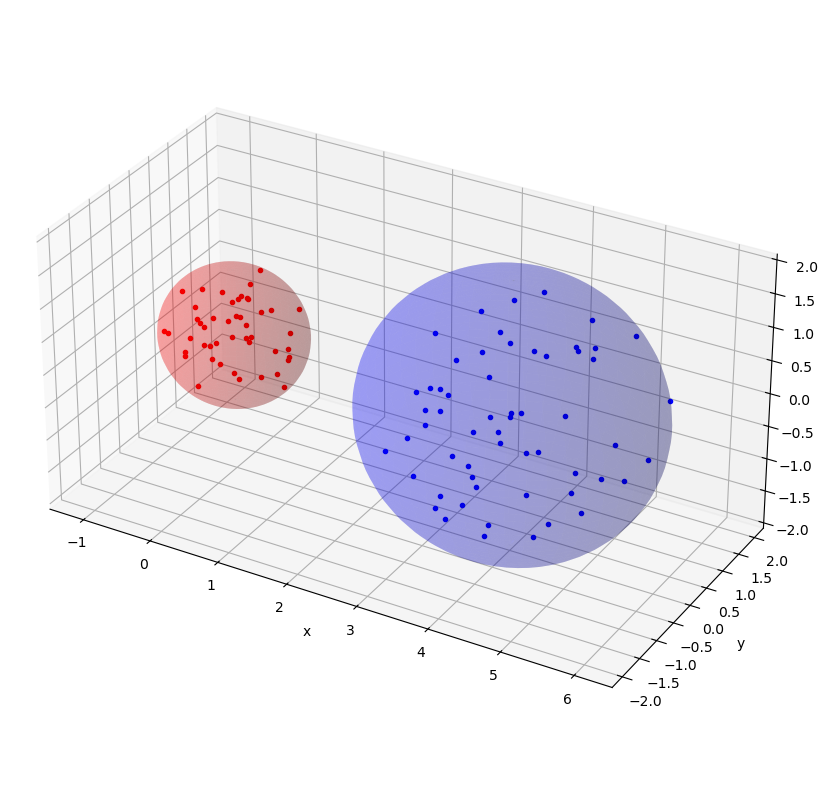

In [12]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(X1, Y1, Z1, 'r.')
ax.plot(X2, Y2, Z2, 'b.')

ax.plot_surface(x1, y1, z1, color="red", alpha=0.2);
ax.plot_surface(x2, y2, z2, color="blue", alpha=0.2);

ax.set_box_aspect((np.ptp(np.concatenate([X1, X2])), np.ptp(np.concatenate([Y1, Y2])), np.ptp(np.concatenate([Z1, Z2]))))
ax.set(xlabel="x", ylabel="y", zlabel="z");

#### Monte Carlo sampling

* We only need to sample *inside* the spheres because the charge density is 0 outside and does not contribute to the integral.
* The 6-dimensional hypervolume $V$ is the product of two sphere volumes because the spheres do not overlap.

In [13]:
V = (4/3 * np.pi)**2 * (R1 * R2)**3

r1_samples = sample(r1_values, R1)
r2_samples = sample(r2_values, R2)

Nmin = min(len(r1_samples), len(r2_samples))
f = 0.
for i in range(Nmin):
    x1, y1, z1 = r1_samples[i]
    x2, y2, z2 = r2_samples[i]
    f += (rho1 * rho2)/np.sqrt((x1 - x2 - d)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    
U_mc = V * f / Nmin    # MC integral
U_exact = V/d
error = 1 - U_mc/U_exact

# divide by Q1 Q2 = rho1 rho2 V
Q1Q2 = rho1 * rho2 * V
print(f"U_mc/V = {U_mc/Q1Q2} (N={Nmin} samples)")
print(f"exact = {U_exact/Q1Q2}, error = {error}")

U_mc/V = 0.24427410577480033 (N=47 samples)
exact = 0.25, error = 0.022903576900798694
